In [ ]:
%matplotlib inline

import time

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import dumbo

# DumBO: The simplest Bayesian optimizer

**tldr** Teach the basic concepts of Bayesian optimization by building a simplistic optimizer.


Engineers and scientists use Bayesian optimization to tune recommender systems used in social media, streaming video, etc.; ML/AI models; a free electron laser used for physics, chemistry and other experiments; software and hardware systems; and much more. In this article, we’re going to design a simple Bayesian optimization algorithm — DumBO — and build it from scratch with NumPy. We’ll discuss and implement the core aspects of a Bayesian optimizer: a surrogate model, an acquisition function, and an embedded, offline optimizer. Finally, we’ll apply DumBO to an ML hyperparameter optimization task. We’ll also see what makes Bayesian optimization different from related algorithms and well-suited to the types of problems mentioned above.

## The setting

Let's imagine that you want to maximize the revenue of your awesome new product. Maybe the product is a new AI-powered marvel that charges a fee for each API call. Maybe there are multiple tiers of API call. Maybe some customers get special rates for long-term commitment. There's some complexity, but since your business survives by revenue, it's clear that your metric is revenue/day.

You configure your system with a file containing multiple feature flags, thresholds, weights, etc. The values in the config file affect the behavior of the AI model, the latency of the model's responses, the throughput of the API endpoint, and even which version of the AI model gets queried.

You presume that the config settings in place right now are not the ones that produce the maximum revenue. It's not that you didn't choose reasonable settings. The system runs, and users like it, after all. But would more people sign up if you used Alan's version of the model instead of Ada's? They used very different -- but equally sensible -- approaches to model building, so it's not obvious which one is better. Also, the config parameters that control the throughput and latency seem to fight each other. It's really not clear what values would work best -- especially since the objective is to increase *revenue* not to achieve any particular latency or throughput.

You could just try out a few different configs and see what revenue they produce. but there are multiple parameters to consider, the revenue varies a lot from day to day even when you don't change the config, and you don't want to unnecessarily expose users to wild swings in API behavior.

It's this kind of problem to which we apply Bayesian optimization:
- The metric, or *objective*, is expensive to measure. It might take time, incur risk, or just cost money to measure the value of a config.
- The measurements are noisy due to natural variation in the system.
- While you can measure metric values for a config, you can't measure helpful things like first or second derivatives of the metric with respect to the parameters. We usually call this type of system a "black box".

In summary, Bayesian optimization is said to perform **black-box optimization of noisy, expensive objectives**. When the objective is measured by running an experiment, as is the case with your API, we say that a Bayesian optimizer is being used for **experimental optimization**.

Let's build the simplest Bayesian optimizer we can and use it to optimize the revenue of your API.

Since the API in the story above is just make-believe, we can't really run it and measure the revenue. Instead, we'll write a simple Python function, `measure()`, as a stand-in for measurements of revenue.

In [ ]:
def measure(x):
    return float(1 - .0950 + (
        -(((x - .3333)**2).mean())
        + .1*np.sin(30*x).mean()
        + .01*np.random.normal()
    ))

Think of `measure()` as a simulation of your whole system. The argument `x` represents the values in the config file. The output of `measure()` is revenue. Revenue is a little noisy -- as simulated by `.01*np.random.normal()`. A real measurement might take three days to run, so `measure()` simulates a three-day process.

For the sake of discussion below, I'm going to call the revenue `y`. Then we can compactly describe the way that revenue varies with the values in the config file as the function `y(x)`. Given a single value of `x`, we can determine (to within the noise) `y` by `y = measure(x)`.

That's the system, expressed in Python. Now let's find the config that maximizes revenue -- I mean the `x` that maximizes `y`.

## The Algorithm

Bayesian optimization has three pieces:

- **Surrogate function**: A model of the function `y(x)`. This is a regression fit to the measurements. The regression has the important property that it estimates not only the expected value of `y(x)` -- call it `y_ex(x)` -- but also the uncertainty in `y(x)`, `y_se(x)`.
- **Acquisition function**: A function (analytic, implemented in Python) of the outputs of the surrogate: `af(y(x), y_se(x))`. It tells how much we desire to measure the value of `y` at a given point `x`.
- **Optimizer**: We maximize `af(y(x), y_se(x))` over `x`. In words: We find the value of `x` that is the most desirable to measure.

Actually, there's a fourth piece, initialization. It's underappreciated, perhaps, because it usually just comes down to choosing one or more random (or [quasi-random](https://en.wikipedia.org/wiki/Low-discrepancy_sequence)) starting values.


When initializing with a single random value, the algorithm looks like this:

```
Init: Measure one or more (quasi-)random values of `x`, and create a data set containing x and y(x).

10. Build a surrogate from the data set.
20. Optimize an acquisition function to find the most desirable x to measure.
30. Take a measurement at x, y(x), add it to the data set.
40. GOTO 10
```

Notice that you collect all of your measurements in a data set, so that every time you build a surrogate you use all of the data collected so far. A Bayesian optimizer is *data efficient*, in part, because it uses every measurement collected so far to decide where to measure next. (Not all optimization algorithms work this way.)

Let's walk through each step in the algorithm above and build the simplest version of it that we can. For example, for the `Init` step, we'll just measure a single random value of `x` and put it (and `y(x)`) in a data set.

Next, we'll make a simple surrogate.
   

## Surrogate function

The surrogate function is a regression of the measured values `y(x)` on `x`. The surrogate provides estimates of `y(x)` at unmeasured values of `x`. Interestingly, it also provides estimates of the uncertainty of `y(x)`. We'll call the two surrogate outputs the expectation and the standard error: `y_ex(x)` and `y_se(x)`.

Bayesian optimization algorithms usually use an ML method called [Gaussian process regression](http://krasserm.github.io/2018/03/19/gaussian-processes/), or GPR, for the surrogate. But not us. We're going to keep it simple. Dumb, even.

When the surrogate is asked, "What are your expectation and standard error at `x`?", it will look for the measurement in the data set that is closest to `x`, call it `y_nn(x_nn)` and report:
```
y_ex(x) = y_nn(x_nn)
y_var(x) = distance(x, x_nn)
y_se(x) = np.sqrt( y_var )
```
In other words:

- The expectation, `y_ex(x)`, is the `y` value of the nearest-neighbor measurement.
- To make an estimate of `y_se(x)`, we'll first estimate the variance, `y_var(x)` as the distance to the nearest neighbor, then return `y_se(x) = sqrt(y_var(x))`.

It's simple, but it captures basic properties of GPRs:

- Estimates of `y(x)` and `y_se(x)` are based on distances to measurements.
- `y_se(x)` increases with distance from measurements.
- `y(x)` are more similar to nearer measurements than to further measurements.

The implementation of the surrogate is:

In [ ]:
def surrogate(x_m, y_m, x):
    distance = np.sqrt( ((x - x_m)**2) )
    i = np.argmin(distance)
    y_ex = y_m[i]
    y_var = distance[i]
    y_se = np.sqrt(y_var)
    return y_ex, y_se

Let's take a look at the surogate function after we've initialized with a single measurement. We'll take `x` as a single real parameter in one dimension lying in `[0,1]`, and measure one value at `x=0.5`. Say we measure `y(x=0.5) = measure(x=0.5) = 0.947`.

In [ ]:
# Take one measurement at x=0.5
x_m = np.array([.5])
y_m = np.array([0.947])


# Choose some values of x at which to compute the surrogate's estimates.
x = np.linspace(0, 1, 100)
y_and_se = np.array([surrogate(x_m, y_m, xx) for xx in x])

# The surrogates estimates of the expectations and standard errors of y.
y_ex = y_and_se[:,0]
y_se = y_and_se[:,1]

# Pretty plot
plt.fill_between(
        x,
        y_ex - y_se,
        y_ex + y_se,
        alpha=.5,
    linewidth=1
    );
plt.plot(x, y_ex, '--', color="#777777")
plt.plot(x_m[0], y_m[0], 'ok', fillstyle='none');
plt.xlabel('x')
plt.ylabel('y')
plt.title('Surrogate function\nOne measurement in one dimension')
plt.show()

Notice how the best estimate of `y(x)` is everywhere equal to 0.947, since, being the only measurement, `x=0.5` is the nearest measurement all other `x` values.

Also note that the standard error, `y_se(x)`, represented by the height of the blue region, grows with distance from the measurement.


## Acquisition function

Typically we're interested in measuring points where `y` is expected to have a high value, because, after all, our goal is to get the API to produce revenue (`y`) and measuring revenue means running the app and *producing* revenue.

We're interested in one other thing, though: Improving the surrogate. The better the surrogate, the better decision we'll make about where to measure. To improve the surrogate we measure at `x`'s where `y_se(x)` is larger. When `y_se(x)` is larger, we are more uncertain of the true value of `y(x)`. Measuring at `x` reduces `y_se(x)` of the next surrogate.

Summarizing: We desire to choose an `x` that will both produce good revenue and be a good data point for improving the surrogate. In ML-speak, we want to *balance exploitation with exploration*.

A simple acquisition function that balances exploitation and exploration is called **upper confidence bound** (UCB). It is the sum of two terms:

- exploitation: y_ex
- exploration: y_se

Now, UCB has a reputation for exploring a little too much, so people often use an acquisition function called **expected improvement**, which doesn't explore too much.

Expected improvement is a more complicated function to describe and implement. Wanting to be simple, DumBO will stick with UCB and just divide the exploration term by two (reduce exploration).

In [ ]:
def acquisition_function(y_ex, y_se):
    return y_ex + y_se/2

## Optimizer

We're only going to optimize over a one-dimensional `x` in this example. That makes optimization easy. We just generate a bunch of evenly-spaced `x` values and choose the one that maximizes `acquisition_function(y_ex(x), y_se(x))`. This is sometimes called a grid search (or a sweep).

In [ ]:
def optimize(x_m, y_m):
    x = np.linspace(0,1,1000)
    af = np.array([acquisition_function(*surrogate(x_m, y_m, xx)) for xx in x])
    return x[np.argmax(af)]

Using a one-dimensional `x` also happens to make visualization and explanation easier, so it's a good place to start.

Notice that there's an optimizer embedded in our Bayesian optimizer. The optimizer used in this step is of a different kind than a Bayesian one. It expects the function it's optimizing -- `acquisition_function()` -- to be fairly fast to evaluate. It will take microseconds to call `acquisition_function()` rather than the days it takes to call `measure()`.

Bayesian optimization (BO) packages may employ, at this step, optimizers such as [conjugate-gradient (CG)](https://en.wikipedia.org/wiki/Conjugate_gradient_method), [BFGS](https://en.wikipedia.org/wiki/Broyden–Fletcher–Goldfarb–Shanno_algorithm), [CMA-ES](https://arxiv.org/abs/1604.00772), or [stochastic gradient descent (SGD)](https://leon.bottou.org/research/stochastic). Compare them:

| Algorithm | Derivatives? | Data Used | Noise Handling |
| --- | --- | --- | --- |
| CG | 1st, 2nd | Current | None |
| BFGS | 1st | Current | None |
| SGD | 1st | Recent | Sampling |
| CMA-ES | None | Recent | Sampling |
| BO | None | All | Modeling |
Table 1. Comparison of optimization algorithms

Some algorithms use only the current function values (and derivatives) measured. Some use the last few measurements. Some algorithms ignore noise. Some rely on repeated samples to "average out" the noise. BO uses all data and models the noise directly. These properties make it effective at solving industrial problems where the number of measurements must be kept small, and the measurements are unavoidably noisy.

When it's time to optimize the acquisition function, one of the other optimizers on the list is more appropriate. After all, the acquisition function is a pure mathematical function, of which you could calculate derivatives if you desired. The same applies to the underlying surrogate.

The open source Bayesian optimization package [Ax](https://ax.dev) applies [PyTorch's](https://pytorch.org) auto-differentiation to the acquisition function (and surrogate). This way, it can use BFGS to optimize the acquisition function. Another package, [SKOpt](https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html), also uses BFGS, but calculates the gradients without auto-differentiation. In instances where a non-differentiable acquisition function or surrogate is used, for example, one might use CMA-ES as the embedded optimizer.

DumBO keeps it simple, however, by using grid search. Let's see it in action.

# A run of DumBO

Below we'll animate a Bayesian optimization, one measurement at a time.

At each iteration, we'll:
- Measure a value using `measure()`.
- Estimate `y_ex(x)` and `y_se(x)` with `surrogate()`.
- Optimize (with `optimize()`) over the UCB acquisition function, `acquisition_function()` to find the most desirable point to measure next.

You'll see two plots:
1. Left: The surrogate and measurements
2. Right: The best measurement so far vs. iteration number

In [ ]:
# Helper, plotting functions
def plot_surrogate(ax, x_m, y_m):
    x = np.linspace(0,1,100)
    ev = np.array([surrogate(x_m, y_m, xx) for xx in x])
    y_ex = ev[:,0]
    y_se = np.sqrt(ev[:,1])
    
    ax.plot(x_m, y_m, 'o');
    ax.plot(x, y_ex, '--');

    ax.fill_between(
        x,
        y_ex - y_se,
        y_ex + y_se,
        alpha=.5,
    linewidth=1
    );
    
def vline(ax, x0, color='black'):
    c = ax.axis()
    ax.autoscale(False)
    ax.plot([x0, x0], [c[2], c[3]], '--', linewidth=1, color=color)
    
def plot_both(x_m, y_m, trace):
    phi = ( 1 + np.sqrt(5) ) / 2
    xlabel = 'number of measurements'
    width = 10
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(width, width/phi/phi))
    plot_surrogate(ax1, x_m, y_m)
    x_max = x_m[np.argmax(y_m)]
    ax1.set_title(f"x_max = {x_max:.4f}")
    vline(ax1, x_max)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('x$100,000')
    ax2.plot(trace, '--');
    ax2.plot(y_m, '.k', alpha=.5);
    ax2.set_title(f'y_max = {y_m.max():.4f}')
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel('x$100,000')
    
    plt.show()

In [ ]:
# Animation

# A seed makes this notebooks' results reproducible
# Feel free to change this value or comment out
#  the line altogether.
np.random.seed(3)

# Initialize by measuring at 0.5
x_m = np.random.uniform(size=(1,))
y_m = np.array([measure(xx) for xx in x_m])

# Collect a trace of best-y-so-far
trace = [y_m[0]]

# Iterate
for _ in range(15):
    # Find most desirable x to measure
    x = optimize(x_m, y_m)
    
    # Measure y at x
    y = measure(x)
    
    # Make plots
    plot_both(x_m, y_m, trace)
    
    # Add measurement to data set
    x_m = np.append(x_m, x)
    y_m = np.append(y_m, y)
    trace.append(y_m.max())

    # Pause to allow you to marvel at the plots
    time.sleep(.1)

If you think that the surrogate on the left looks a little too jagged, you're not alone. A Bayesian optimizer that uses GPR would produce a much smoother surrogate.

On the right we see that the optimizer finds new maxima but then proceeds to measure worse values of `y` afterward. It's "exploring" by proposing `x` values where it is more unsure of what value of `y` will be measured. As the surrogate improves (uncertainty lessens) the measurements tend to be closer and closer to the maximum.

You've done it. You found a configuration (`x`) that produces more revenue (`y`) than your initial config file did.

Let's turn now to another situation where Bayesian optimization can be fruitfully applied, hyperparameter optimization of ML/AI models.

# Hyperparameter optimization

Machine learning models -- from the very large, like [GPT-3](https://en.wikipedia.org/wiki/GPT-3), to the more typical size that you might train in your work or studies -- rely on the setting of multiple hyperparameters. Hyperparameters are design decisions that are made before training, like
- How many layers in my neural net?
- How strong should the L2 penalty be?
- How high should the learning rate be?
- Which optimizer should I use?
- How many signals (features) should I include?

and so on. Your choice of hyperparameters will affect how well the model works out-of-sample -- how well it generalizes -- as measured by the average error on a held-out test set of data. That evaluation will be a single number (test-set error; without derivatives). In many projects, training a model with a single set of hyperparameters can take a long time. Checking Table 1, we see that this is a problem well-suited to either CMA-ES or Bayesian optimization.

Looking at [XGBoost](https://xgboost.readthedocs.io/en/stable/), the popular gradient boosted decision tree package, we find hyperparameters like:
- max_depth - The maximum depth of a tree.
- subsample - Subsample ratio of the training instances.
- min_child_weight - Minimum sum of instance weight needed in a child.
- colsample_bytree - The subsample ratio of columns when constructing each tree.
- eta - Step size shrinkage used in update to prevents overfitting.
- num_parallel_tree - Number of parallel trees constructed during each iteration.

The descriptions above are copied from the [XGBoost documentation](https://xgboost.readthedocs.io/en/stable/parameter.html). I won't pretend to deeply understand what they're all doing. I *definitely* won't claim to know how they all interact to affect the out-of-sample performance of a model. I will probably use the default values and tweak them a little one by one to see how the test-set error changes before giving up. This suboptimal, to put it kindly.

Fortunately, we have DumBO. DumBO (and, indeed, other Bayesian optimizers) can find good settings for hyperparameters like these automatically.

## Digit Recognition

We'll train a classifier on a toy data set provided by [SKLearn](https://scikit-learn.org/stable/datasets/toy_dataset.html), using XGBoost as the model.

First, load the data.

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import xgboost as xgb

np.random.seed(17)
digits = load_digits()

n_samples = len(digits.images)
x_train, x_test, y_train, y_test = train_test_split(
    digits.images.reshape((n_samples, -1)), 
    digits.target, test_size=1/2, shuffle=True
)
digit_data = (x_train, x_test, y_train, y_test)

Next, create a function to measure the quality of a set of hyperparameters, `measure_test_accuracy()`. This function will fit a model and return the average error of its classifications on a test set of data.

In [ ]:
def convert_to_hp(x):
    x = x.flatten()
    return {
        'max_depth': int(1 + 7*x[0] + .5),
        'subsample': x[1],
        'min_child_weight': 1 + 99*x[2],
        'colsample_bytree': x[3],
        'eta': x[4],
        'num_parallel_tree': int(1 + 9*x[5] + .5),
    }

def measure_test_accuracy(digit_data, x):
    x_train, x_test, y_train, y_test = digit_data
    xgb_model = xgb.XGBClassifier(
        objective="binary:logistic",
        **convert_to_hp(x)
    )
    xgb_model.fit(x_train, y_train)
    return xgb_model.score(x_test, y_test)

There are six hyperparameters, so this is an optimization in a six-dimensional space (`num_dim=6`). We initialize the optimization by choosing a random set of hyperparameters, described by a point in the six-dimensional space.

In [ ]:
np.random.seed(2)
num_dim = 6
x_m = np.random.uniform(size=(1, num_dim))
y_m = np.array([measure_test_accuracy(digit_data, x_m)])

y_best = y_m[0]
x_best = x_m[0]
trace = [y_best]

We follow the same pattern as before:

    1. Optimize the acquisition function to suggest a new set of hyperparameters to measure
    2. Measure them with `measure_test_accuracy()`
    3. Repeat until done
    
That last step is a little discomfiting. One could devise statistical rules to decide when to stop, but the practical answer comes from the problem statement: expensive objective. The number of times you take a measurement may be limited mostly by how much time, money, or risk you can afford to expend on the optimization process. This is called your *budget*. We'll set a budget of 20 iterations for this task.

In [ ]:
for _ in range(20):
    x = dumbo.optimize(x_m, y_m)
    y = measure_test_accuracy(digit_data, x)
    x_m = np.append(x_m, x, axis=0)
    y_m = np.append(y_m, y)
    if y > y_best:
        y_best = y
        x_best = x
    trace.append(y_best)
    clear_output(wait=True)
    plt.plot(trace, 'k.--');
    plt.title(f"y_best = {y_best:.4f}")
    plt.xlabel('iterations')
    plt.ylabel('y, test-set accuracy')
    plt.show()
    
import pprint
print ("The best hyperparameters are:")
pprint.pprint(convert_to_hp(x_best))

There you have it. A fine set of hyperparameters, without any guess-work.

Before we wrap things up, I'd like to point out that research in Bayesian optimization is [ongoing, varied, and pushing the state of the art](https://arxiv.org/abs/2206.03301). Let's look at an interesting recent development in Bayesian optimization: High-dimensional parameter spaces.

# High-dimensional problems

No algorithm is meant to solve all problems. Bayesian optimization is designed for problems with expensive objectives, where your budget (number of measurements) will be small. Generally speaking, the more parameters you have to optimize the more measurements you'll need. So it stands to reason that Bayesian optimization would only be applied to problems with few parameters. But not everyone is reasonable.

Researchers like to try new things, and they like a challenge -- like applying Bayesian optimization to higher-dimensional problems. To make Bayesian optimization viable in high dimensions, you would have to be able to evaluate the objective

    - quickly enough so that we could take many measurements, but
    - not so quickly that it takes longer to propose a new measurement than to take it

That second condition is important because Bayesian optimizers are usually much slower to propose a new `x` to measure than the other optimizers in Table 1. A set of problems that are "fast enough but not too fast" and may have many dimensions (parameters) come from simulation and ML/AI hyperparameter optimization.

Simulations take many forms. Something called a simulation might take anywhere from milliseconds to days to complete. It depends on the problem. A simulation that consists of a pure function -- ex., the Henon map, used in Chaos research -- might take milliseconds to compute. A simulation that analyzes large amounts of data -- ex., trading "backtests" or recommender system simulations -- might take minutes to hours. A still larger, detailed scientific calculation might take days.

Also ML/AI models can take any amount of time from seconds to days to fit. Some giant models take even longer.

High-dimensional Bayesian optimization is appropriate for objectives that take seconds to multiple minutes to compute.


## Curse of dimensionality and Trust Regions

The fundamental problem with optimizing in high-dimensional spaces is that there's just so much space! Think of it this way: In the function `optimize()`, we did a grid search in 1D by measuring 10 equally-spaced `x` values. If we extended that approach to 2D, we'd measure a 10x10 grid of `x` values, taking 10x10 = 100 measurements. In 3D, we'd take 10x10x10 = 1000, and so on. See the pattern? If we tried a grid search over 100 parameters, we'd have to measure 10x10x...x10 = 10^100 -- a [googol](https://en.wikipedia.org/wiki/Googol) of measurements. This is called the *curse of dimensionality*.

One approach optimization algorithms take to dealing with high-dimensionality is to search only near the best `x` value measured so far. You can have some faith that near the best `x` the objective will be pretty good -- maybe even better than the best so far. This is called *local search*, and the region where you permit searching is called a *trust region*. Bayesian optimization's approach -- by contrast -- of always searching the entire space is called *global search*.

<center>
<figure>
    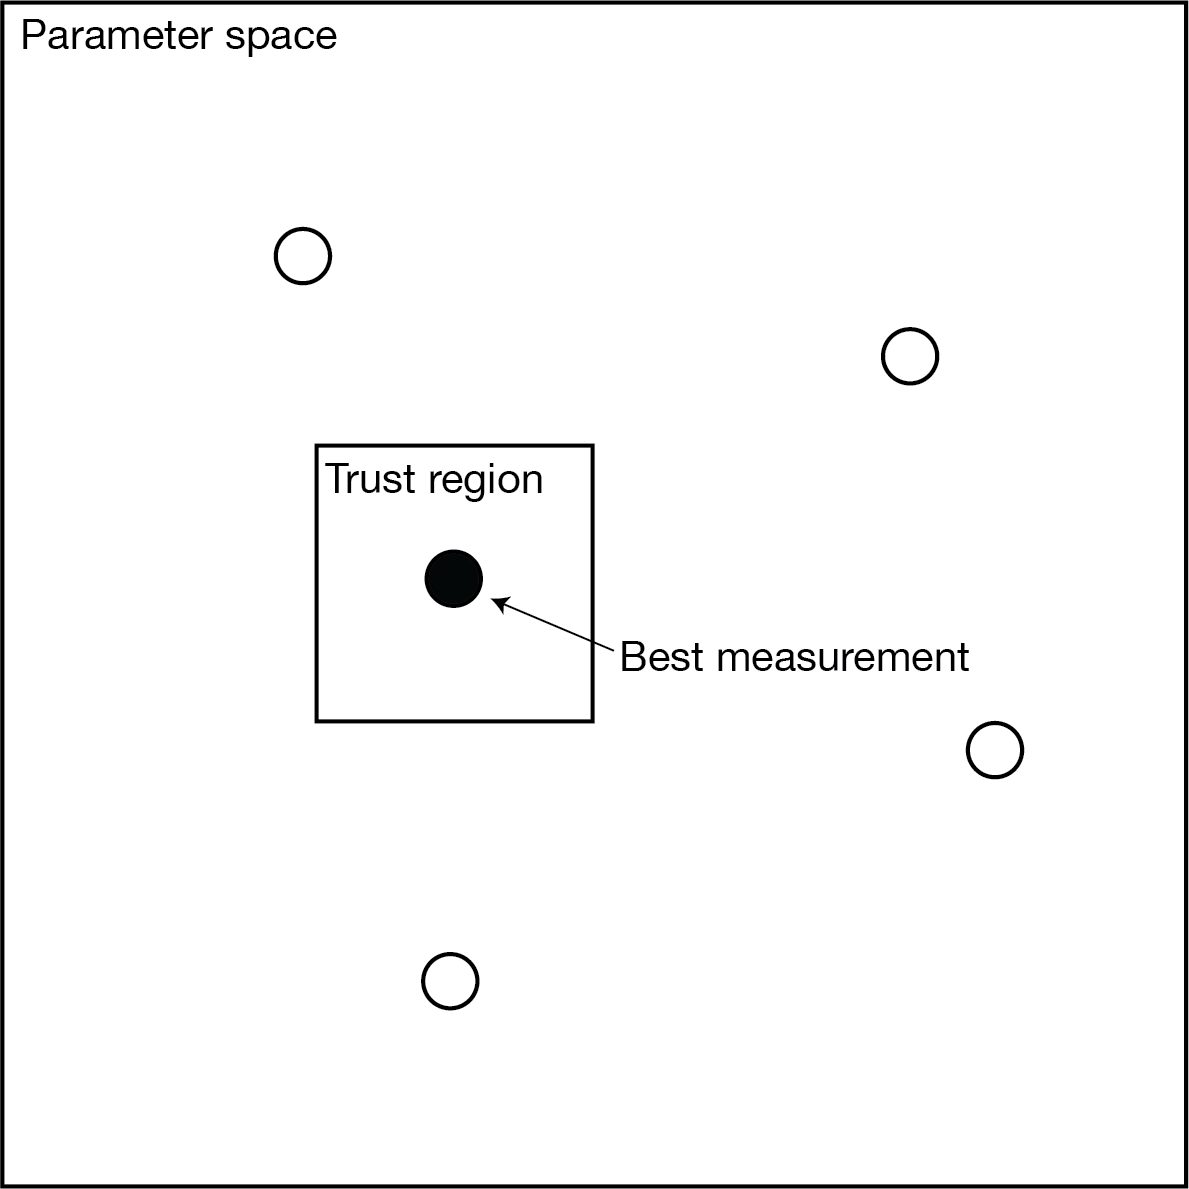
  <figcaption>Figure 1. A trust region</figcaption>
</figure>
</center>

Figure 1 shows a trust region in a 2D parameter space. The circles mark the parameter values where measurements have been taken. The filled circle is the measurement with the highest metric value -- the best measurement so far. The offline optimizer will search only the trust region (the small box) for a new parameter value to measure.

A recent paper applies a trust region to Bayesian optimization, creating **T**r**u**st **R**egion **B**ayesian **O**ptimization, or [TuRBO](https://arxiv.org/pdf/1910.01739.pdf).


Let's give DumBO a trust region, too. First set the size of the trust region. TuRBO does this based on some cleverness in the GPR and feedback from previous measurements. We'll avoid cleverness and just note that:

1. More dimensions means less trust (smaller trust region)
2. Start with a large trust region -- the whole space, in fact -- to explore globally and find a probably-better-than-average region of the space. Then shrink the trust region over time.

We implement these heuristics like this:
```
trust_region = max(1.0/num_dim, 1.0/(1 + i_meas))
```
where `num_dim` is the number of dimensions (or parameters), and `i_meas` is the number of measurements that have been taken so far.


Before we dive into this 100-dimensional pool, there's one small problem to fix. If the measurements are noisy, how do you know which one is the best so far? For example, if you have one measurement with `(y,se) = (10,2)` and another with `(y,se) = (11,4)`, which is better? We don't know, but we have to pick one. Fortunately, there's one weird trick for situations like this: Thompson sampling

## Thompson Sampling

When you have multiple noisy measurements, `m_i = (y_i, se_i)`, and you want to pick a "best", i.e., the one with the highest true value (expectation) of `y`. A good strategy is to take a Thompson sample:

1. Treat each measurements like a Gaussian distribution, `N(y_i, se_i**2)`, and take one sample from each: `ts_i = y_i + se_i * np.random.normal()`.
2. Pick the largest sample: `np.argmax([ts_0, ts_1, ts_2, ...])`.

If a Gaussian distribution is good model of the real data-generating process, i.e. what's really happening when you take a measurement, then taking a draw from it is a simulation of a measurement. In step (1) you simulate one measurement of each `m_i`, and each has some probability of being the max, call that `p_max_i`. By picking the max of the samples, in step (2), you are creating the decision rule `p_pick_i = p_max_i`, the probabiility of picking measurement `m_i` is the same as the probability that it would be the maximum if you -- hypotheticall -- were to proceed to really measure all of them.

The decision rule, `p_pick_i = p_max_i`, is an optimal strategy for the [multi-armed bandit](https://en.wikipedia.org/wiki/Multi-armed_bandit) problem. In a multi-armed bandit, your job is to find the best `m_i` among a finite set of parameter values. In other words, `x` is [categorical](https://en.wikipedia.org/wiki/Categorical_variable) (like an enum) instead of continuous (like a float).

DumBO will pick its max using a Thompson sample, like this:

In [ ]:
def ts_argmax(x_m, y_m, se):
    ts = y_m + se*np.random.normal(size=(len(y_m),))
    return x_m[np.argmax(ts)]

To summarize, one iteration of Bayesian optimization in a high dimensional space will look like this:

1. **Thompson sample**: Pick a "best measurement"
2. **Trust region**: Define a small bounding box around the best measurement
3. **Optimization**: Search the trust region for the parameter value that maximizes the acquisition function
4. **Measurement**: Run an experiment to measure the parameter value proposed by the optimization

We've figured out how to avoid "over-exploring" -- use a trust region -- and how to pick a "best" measurement even though measurements are noisy. But what about the fact that high-dimensional optimizations require lots of measurements? Bayesian optimization looks at all measurements collected when proposing a new `x` to measure. Therefore, every iteration of the optimization should be a little slower than the last.

Recent research has proposed a fix for that, too.

## Sparsity

To cope with a large number of measurements, Baysian optimizers use various tricks to make the measurement set smaller before using it to propose new measurements. A simple trick might be to just take a random, small subset of the full measurement set and use that. We say that the subset is a "sparse" representation of the measurements.

Other methods try to choose ad optimal subset or to summarize the measurements into a small number of "pseduomeasurements". Whichever sparsification method is used, the result is that the proposal process run more quickly.

To sparsify the measurement set, we'll just run the embedded optimizer (`dumbo.optimize()`) over the 50 measurements. Then, no matter how long we run the optimization, no iteration will ever be slower than the 50th iteration.

Finally, let's optimize.

## DumBO in 100 dimensions

Define a measurement "simulator" again:


In [ ]:
def measure_nd(x):
    return float((
        -(((x - .3333)**2).mean())
       + .1*np.sin(30*x).mean()
       + .01*np.random.normal()
    ))

Optimize as before, except only allow the embedded optimizer to propose `x` values within the trust region, like this:

```
bounds = np.array( [
    np.maximum(0., x_best-trust_region/2),
    np.minimum(1., x_best+trust_region/2)
] )
```


The variable `se` tells the noise level of the measurements.

In [ ]:
np.random.seed(17)

num_dim = 100
sparsity_length = 25

x_m = np.random.uniform(size=(1, num_dim))
y_m = np.array([measure_nd(xx) for xx in x_m])
se = .01

trace = [y_m[0]]
for i_meas in range(100):
    trust_region = max(1.0/num_dim, 1.0/(1 + i_meas))
    x_best = ts_argmax(x_m, y_m, se)
    bounds = np.array( [
        np.maximum(0., x_best-trust_region),
        np.minimum(1., x_best+trust_region)
    ] )
        
    x = dumbo.optimize(x_m[-sparsity_length:], y_m[-sparsity_length:], num_iterations=1000, bounds=bounds)
    y = measure_nd(x)

    x_m = np.append(x_m, x, axis=0)
    y_m = np.append(y_m, y)
    trace.append(y_m.max())
    clear_output(wait=True)
    #plt.show()
    plt.plot(y_m, '.k')
    plt.plot(trace, 'k--');
    plt.title(f"y_best = {y_m.max():.4f}\ntrust_region = {trust_region:.3f}")
    plt.xlabel('iteration')
    plt.ylabel('y')
    plt.legend(['y_m', 'y, max so far'], 'lower right')
    plt.show()

Notice how the measured values, `y_m`, are near the max-so-far dashed line. The nearness is caused by the trust region. It restricts proposed measurements to be close -- in `x` -- to the max-so-far measurements, so they also fall close in `y`.

Higher-dimensional Bayesian optimization is enabled by a trust region, Thompson sampling, and sparsity.
A trust region limits global exploration. Thompson sampling finds the best measurement among noisy measurements, which becomes the center of the trust region. Sparsity keeps the time to calculate a proposal from increasing inordinately with the number of iterations of the algorithm.

## Awesome Bayesian Optimization

Bayesian optimization is a powerful, flexible, and adaptable approach to optimization. We saw in this article that it can be used for noisy, expensive-objective problems, like tuning production engineered systems. It can also be applied to higher-dimension problems, such as optimizing moderately-fast simulations.

There are yet more tools in the Bayesian optimization toolkit. It can support:

- [Mixed variable types](https://ax.dev/docs/models.html): You may optimize over continuous variables -- as we did here -- as well as ordinal (i.e., integer) and categorical (ex., boolean or enum) ones.
- [Multiple objectives](https://botorch.org/docs/multi_objective): Your system may have more than one important metric. You might care about revenue as well as direct measures of customer engagement or satisfaction, for example. You can meaningfully consider all of them while optimizing.
- [Multiple fidelities](https://botorch.org/tutorials/Multi_objective_multi_fidelity_BO): If you want to optimize a production system *and* you have a simulator of that system, you can incorporate measures taken from both. The simulated measurements are cheap to make and useful information that guides the search for higher production metrics.
- [Contraints](https://botorch.org/docs/constraints): Sometimes, while optimizing one metric, you may desire to not harm a different metric. You want to constrain the second matric by a lower bound. Bayesian optimization supports those kind of constraints.
- Arbitrary measurements: You can build a surrogate with any available measurements. You might, for example, take measurements at parameter values that you've trusted in the past or simply suspect will perform well. In this way you can incorporate your domain knowledge into the optimization process.


Each of these features can be useful in optimizing an industrial system. To start simple, you might try [Ax's service interface](https://ax.dev/versions/0.1.0/tutorials/gpei_hartmann_service.html), then, as your needs become more complex or specific to your system, switch to the [developer API](https://ax.dev/tutorials/gpei_hartmann_developer.html). If you'd like to research or develop your own surrogate or acquisition function, delve into [BoTorch](https://github.com/pytorch/botorch), the lower-level toolkit upon which Ax is built.

## Conclusion

I hope you're convinced of the importance of experimental optimization in industrial settings, and of both the power and flexibility of Bayesian optimization as a method. Additionally, I hope following the development of DumBO has made the basics of Bayesian optimization clear.

You may find this article, formatted as a [Jupyter notebook](https://github.com/dsweet99/dumbo/blob/main/DumBO.ipynb), in [GitHub](https://github.com/dsweet99/dumbo), along with all of the DumBO code.

